In [1]:
from chebGreen import ChebGreen
import numpy as np
import matplotlib.pyplot as plt

from chebGreen.chebpy2 import Quasimatrix
from chebGreen.chebpy2.chebpy import chebfun
from chebGreen.chebpy2 import Chebfun2

# %env TF_MLC_LOGGING=1
# %env TF_CPP_MIN_LOG_LEVEL=2

In [2]:
%%time
Theta = [1,5,10]
domain = [0,1,0,1]
generateData = True
script = "generate_example"
example = "airy_equation"
dirichletBC = True
airy = ChebGreen(Theta, domain, generateData, script, example, dirichletBC)

Generating dataset for example 'airy_equation'
### Example = airy_equation @ theta = 1 ###
Number of samples: 100
Length scale: 0.01
Nf: 500
Nu: 500
Noise: 0%
---------------------------------------
Step = 1/100
Step = 2/100
Step = 3/100
Step = 4/100
Step = 5/100
Step = 6/100
Step = 7/100
Step = 8/100
Step = 9/100
Step = 10/100
Step = 11/100
Step = 12/100
Step = 13/100
Step = 14/100
Step = 15/100
Step = 16/100
Step = 17/100
Step = 18/100
Step = 19/100
Step = 20/100
Step = 21/100
Step = 22/100
Step = 23/100
Step = 24/100
Step = 25/100
Step = 26/100
Step = 27/100
Step = 28/100
Step = 29/100
Step = 30/100
Step = 31/100
Step = 32/100
Step = 33/100
Step = 34/100
Step = 35/100
Step = 36/100
Step = 37/100
Step = 38/100
Step = 39/100
Step = 40/100
Step = 41/100
Step = 42/100
Step = 43/100
Step = 44/100
Step = 45/100
Step = 46/100
Step = 47/100
Step = 48/100
Step = 49/100
Step = 50/100
Step = 51/100
Step = 52/100
Step = 53/100
Step = 54/100
Step = 55/100
Step = 56/100
Step = 57/100
Step = 58/10

cp: savedModels/airy_equation/settings.ini: No such file or directory


Chebfun model added for example 'airy_equation' at Theta = 1.00

Training greenlearning model for example 'airy_equation' at Theta = 5.00
Training with Adam:
Loss at epoch 100: Training = 3.887E-01, Validation = 3.708E-01
Loss at epoch 200: Training = 3.413E-02, Validation = 3.907E-02
Loss at epoch 300: Training = 1.259E-02, Validation = 1.163E-02
Loss at epoch 400: Training = 6.469E-03, Validation = 7.251E-03
Loss at epoch 500: Training = 3.873E-03, Validation = 5.523E-03
Loss at epoch 600: Training = 3.456E-03, Validation = 5.220E-03
Loss at epoch 700: Training = 2.504E-03, Validation = 4.484E-03
Loss at epoch 800: Training = 2.199E-03, Validation = 4.180E-03
Loss at epoch 900: Training = 1.760E-03, Validation = 3.560E-03
Loss at epoch 1000: Training = 1.489E-03, Validation = 3.128E-03
Loss at epoch 1100: Training = 1.275E-03, Validation = 2.810E-03
Loss at epoch 1200: Training = 1.254E-03, Validation = 2.600E-03
Loss at epoch 1300: Training = 1.053E-03, Validation = 2.314E-03
Loss a

In [3]:
airy.G

{1.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     79       [-0.000 -0.000 -0.000 -0.000]
 vertical scale = 0.236540,
 5.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     79       [0.000 0.000 0.000 0.000]
 vertical scale = 0.138765,
 10.0: chebfun2 object
      domain       rank               corner values
 [0,1] x [0,1]     79       [0.000 0.000 0.000 0.000]
 vertical scale = 0.087580}

In [4]:
airy.N

{1.0: chebfun (1 smooth piece)
        interval       length     endpoint values
 [       0,       1]       11  -5.2e-05  0.00018
 vertical scale = 0.00018,
 5.0: chebfun (1 smooth piece)
        interval       length     endpoint values
 [       0,       1]       11   -0.0003 -0.00021
 vertical scale = 0.0003,
 10.0: chebfun (1 smooth piece)
        interval       length     endpoint values
 [       0,       1]       13  -0.00022 -0.00025
 vertical scale = 0.00025}

CPU times: user 23.8 s, sys: 35.4 s, total: 59.2 s
Wall time: 15.7 s


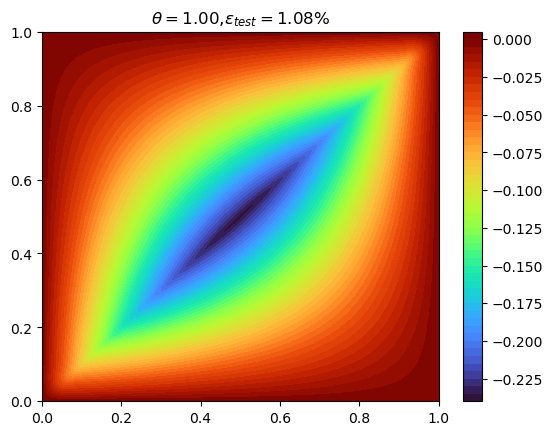

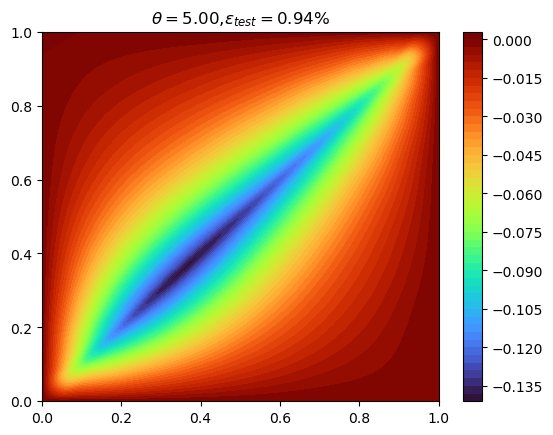

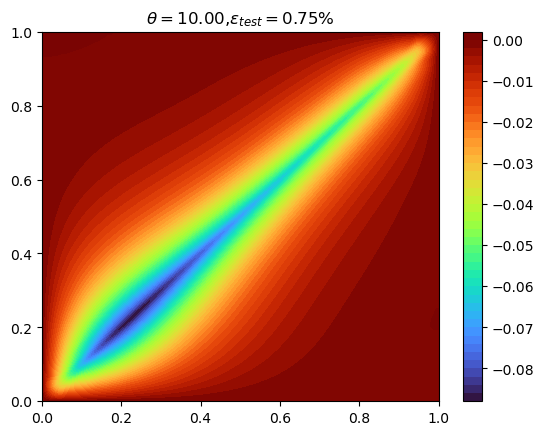

In [5]:
%%time
for t in Theta:
    fig = plt.figure()
    airy.G[t].plot(fig = fig)
    error = airy.computeEmpiricalError(t)
    plt.title(f"$\\theta = {{{t:4.2f}}}$,$\\epsilon_{{test}} = {{{error*100:4.2f}}}\%$")

In [6]:
%%time
u,s,v = airy.G[1].svd()

CPU times: user 2.68 s, sys: 6.63 s, total: 9.31 s
Wall time: 1.44 s


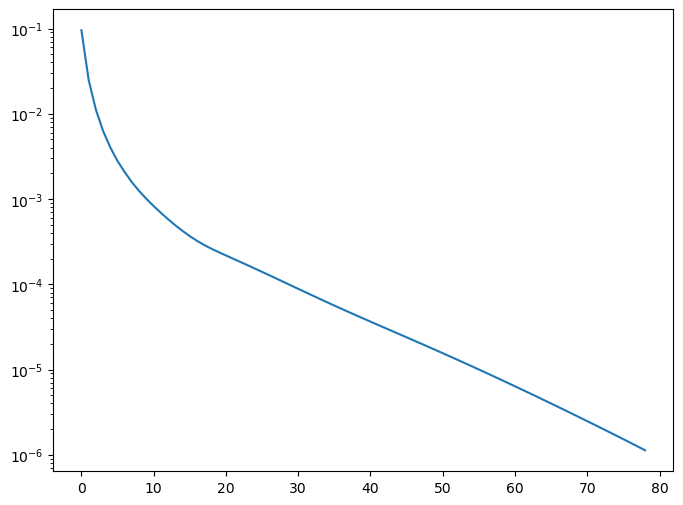

In [7]:
fig = plt.figure(figsize = (8,6))
plt.semilogy(s)

(0.0, 1.0)

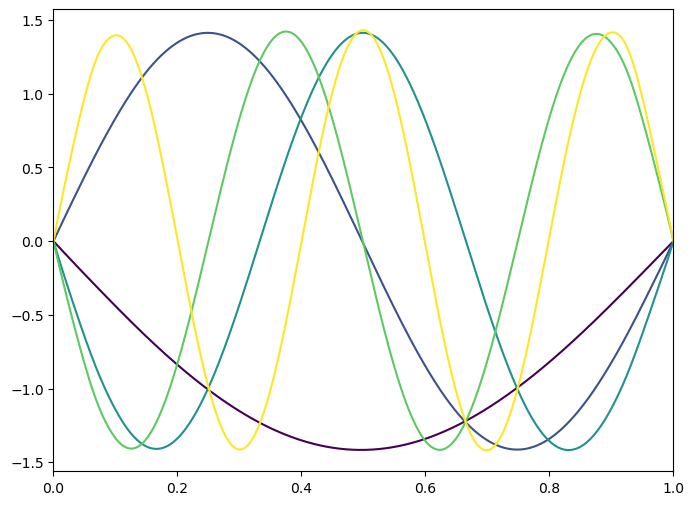

In [8]:
# i = slice(10,20)
i = slice(0,5)
# i = 16
fig = plt.figure(figsize = (8,6))
u[:,i].plot(fig = fig)
# print(np.max(u[:,i].vscale))
# plt.title(f'First {i+1} left singular functions for a Laplacian')
plt.xlim([0,1])
# fig.savefig(f'Laplace-first.png', dpi = fig.dpi)

In [9]:
%%time
theta_ = 7.0
Ginterp, Ninterp = airy.generateNewModel(theta_)

CPU times: user 24.6 s, sys: 36.9 s, total: 1min 1s
Wall time: 11.5 s


In [10]:
validation = ChebGreen([7], generateData = True, script = "generate_example", example = "airy_equation")

Generating dataset for example 'airy_equation'
### Example = airy_equation @ theta = 7 ###
Number of samples: 100
Length scale: 0.01
Nf: 500
Nu: 500
Noise: 0%
---------------------------------------
Step = 1/100
Step = 2/100
Step = 3/100
Step = 4/100
Step = 5/100
Step = 6/100
Step = 7/100
Step = 8/100
Step = 9/100
Step = 10/100
Step = 11/100
Step = 12/100
Step = 13/100
Step = 14/100
Step = 15/100
Step = 16/100
Step = 17/100
Step = 18/100
Step = 19/100
Step = 20/100
Step = 21/100
Step = 22/100
Step = 23/100
Step = 24/100
Step = 25/100
Step = 26/100
Step = 27/100
Step = 28/100
Step = 29/100
Step = 30/100
Step = 31/100
Step = 32/100
Step = 33/100
Step = 34/100
Step = 35/100
Step = 36/100
Step = 37/100
Step = 38/100
Step = 39/100
Step = 40/100
Step = 41/100
Step = 42/100
Step = 43/100
Step = 44/100
Step = 45/100
Step = 46/100
Step = 47/100
Step = 48/100
Step = 49/100
Step = 50/100
Step = 51/100
Step = 52/100
Step = 53/100
Step = 54/100
Step = 55/100
Step = 56/100
Step = 57/100
Step = 58/10

In [11]:
# vmin, vmax = -0.24,0.03
# Gplot = validation.G[theta_]

# xx = np.linspace(domain[0],domain[1],2000)
# yy = np.linspace(domain[2],domain[3],2000)
# x, y = np.meshgrid(xx,yy)
# Gplot = Gplot[x,y]

# fig = plt.figure(figsize = (13,10), frameon=False)
# plt.axis('off')
# plt.gca().set_aspect('equal', adjustable='box')
# levels = np.linspace(vmin, vmax, 50, endpoint = True)
# plt.contourf(x,y,Gplot, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
# # ticks = np.linspace(vmin, vmax, 6, endpoint=True)
# # cbar = plt.colorbar(ticks = ticks, fraction = 0.046, pad = 0.04)

# fig.savefig('E.png', dpi = fig.dpi, bbox_inches='tight', pad_inches=0)

Text(0.5, 1.0, 'Interpolated Model $\\theta = {7.00}$,$\\epsilon_{test} = {3.00}\\%$')

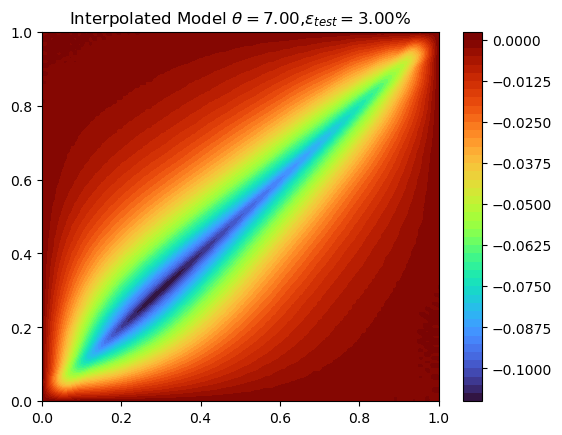

In [12]:
fig = plt.figure()
Ginterp.plot(fig = fig)
error = airy.computeEmpiricalError(theta_)
plt.title(f"Interpolated Model $\\theta = {{{theta_:4.2f}}}$,$\\epsilon_{{test}} = {{{error*100:4.2f}}}\%$")
# fig.savefig(f'poisson_greenlearning.png', dpi = fig.dpi)

Text(0.5, 1.0, 'Validation Model $\\theta = {7.00}$,$\\epsilon_{test} = {0.66}\\%$')

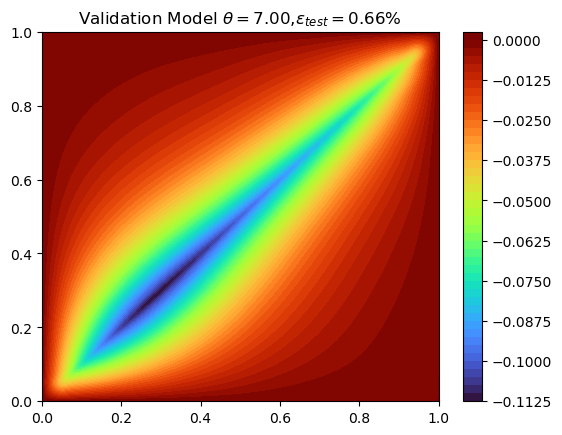

In [13]:
fig = plt.figure()
validation.G[theta_].plot(fig = fig)
error = validation.computeEmpiricalError(theta_)
plt.title(f"Validation Model $\\theta = {{{theta_:4.2f}}}$,$\\epsilon_{{test}} = {{{error*100:4.2f}}}\%$")

In [14]:
def compareGreen1D(interpModel, exactModel, vmin = None, vmax = None):
    domain = interpModel.domain
    xx = np.linspace(domain[2],domain[3],2000)
    yy = np.linspace(domain[0],domain[1],2000)
    x, s = np.meshgrid(xx,yy)
    
    if vmin is None:
        vmin = min(interpModel.min,exactModel.min)
    if vmax is None:
        vmax = max(interpModel.max,exactModel.max)
        
    plt.figure(figsize = (16,6))
    plt.subplot(121)
    
    GInterp = interpModel[x,s]
    
    levels = np.linspace(vmin, vmax, 50, endpoint = True)
    ticks = np.linspace(vmin, vmax, 10, endpoint=True)
    
    surf = plt.contourf(x, s, GInterp, levels = levels, cmap = 'turbo', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    cbar = plt.colorbar(ticks = ticks, fraction = 0.046, pad = 0.04)
    cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks])
    plt.xlabel('$x$', fontsize = 11)
    plt.ylabel('$s$', rotation='horizontal', labelpad=10, fontsize = 11)
    plt.title("Interpolated", fontsize = 14)
    
    GExact = exactModel[x,s]
    
    plt.subplot(122)
    plt.gca().set_aspect('equal', adjustable='box')
    surf = plt.contourf(x, s, GExact, levels = levels, cmap = 'turbo', vmin = vmin, vmax = vmax)
    cbar = plt.colorbar(ticks = ticks, fraction = 0.046, pad = 0.04)
    cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in ticks])
    plt.xlabel('x', fontsize = 11)
    plt.ylabel('s', rotation='horizontal', labelpad=10, fontsize = 11)
    plt.title("Data", fontsize = 14)

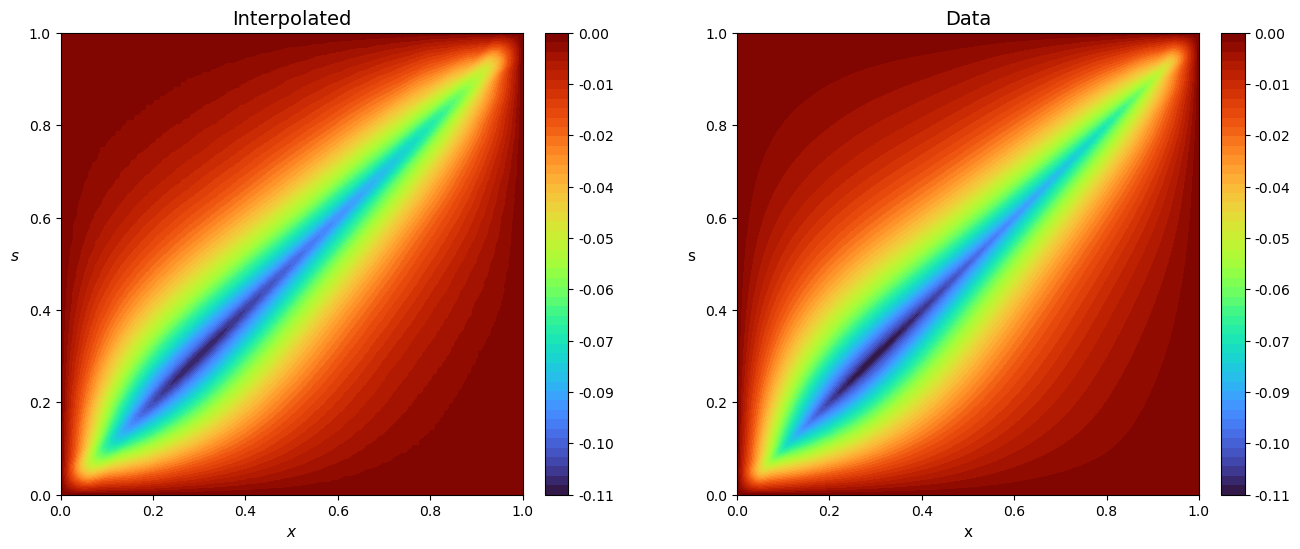

In [15]:
compareGreen1D(Ginterp,validation.G[7])